# Basic Methods for Continuous Time Bewley Model

The following exercises look at the dynamics of consumption and aggregate savings following different types of credit shocks: interest rate spreads or tighter borrowing constraints using numerical methods suggested in Achdou et al. (WP, 2017). 

## 1. Steady State with Two Income Levels using the Explicit Method:
Parameters:

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numba import vectorize, guvectorize, njit
import RognlieCode as r1

# Preferences:
gamma = 1.2
rho = 0.05

# Interest rate:
r = 0.035
# Borrowing constraint:
phi = 0.02

# Income Process:
J = 2
y1 = 0.1
y2 = 0.2
y = np.array([y1, y2])
l1 = 1.5
l2 = 1
la = [l1,l2]
La = np.array([[-l1,l2],[l1,-l2]])

# Grid:
I = 500
amin = -phi
amax = 3
a = np.linspace(amin,amax,I)
da = a[2] - a[1]

# Discrete parameter
Delta = 0.01


Initial guess for the value function:

In [18]:
v0 =(y[:,np.newaxis] + r*a)**(1-gamma)/(1-gamma)/rho
v = np.transpose(v0)

In [19]:
def updatev(V,a,y,La,r,gamma,rho,Delta = 0.01):
    
    I = np.shape(a)[0] 
    J = np.shape(y)[0]
    dVf = np.zeros([I,J])
    dVb = np.zeros([I,J])
    
    dVf[0:I-1,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVf[I-1,:] = 0 
    dVb[1:I,:] = (V[1:I,:] - V[0:I-1,:])/da
    dVb[0,:] = (y[np.newaxis,:] + r*amin)**(-gamma)

    i_v = dVb > dVf
    
    cf = dVf**(-1/gamma)
    sf = np.transpose(y[:,np.newaxis] + r*a) - cf
    cb = dVb**(-1/gamma)
    sb = np.transpose(y[:,np.newaxis] + r*a) - cb
    c0 = np.transpose(y[:,np.newaxis] + r*a)
    dV0 = c0**(-gamma)
    
    iF = sf > 0
    iB = sb < 0
    i0 = 1 - iF - iB 
    iF[I-1,:] = 0
    iB[I-1,:] = 1
    
    dV = dVf*iF + dVb*iB + dV0*i0
    c = dV**(-1/gamma)
    s = np.transpose(y[:,np.newaxis] + r*a) - c
    h = c**(1-gamma)/(1-gamma) + s*dV

    Vi = (h - rho*V + V@La)*Delta + V 
    
    return Vi, s, c

In [20]:
updatev(v,a,y,La,r,gamma,rho)

/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


(array([[-158.40250516, -138.27617447],
        [-158.33472486, -138.24582433],
        [-158.26784465, -138.21614975],
        [-158.20113414, -138.18651378],
        [-158.13459253, -138.15691631],
        [-158.06821905, -138.12735725],
        [-158.00201292, -138.09783652],
        [-157.93597335, -138.06835402],
        [-157.87009959, -138.03890965],
        [-157.80439087, -138.00950332],
        [-157.73884644, -137.98013495],
        [-157.67346554, -137.95080444],
        [-157.60824741, -137.92151169],
        [-157.54319133, -137.89225663],
        [-157.47829656, -137.86303915],
        [-157.41356235, -137.83385917],
        [-157.34898798, -137.8047166 ],
        [-157.28457273, -137.77561134],
        [-157.22031588, -137.74654332],
        [-157.15621672, -137.71751243],
        [-157.09227454, -137.6885186 ],
        [-157.02848862, -137.65956172],
        [-156.96485828, -137.63064173],
        [-156.90138282, -137.60175852],
        [-156.83806155, -137.57291201],


### 1.1 Methods for Value Function Iteration with the Improvement Step
Here comes the main loop for value function iteration. We try to make code more efficient by using improvement step which avoids optimizing every iteration. We extract from this the agents' savings policy functions. 
    

In [21]:
def hh_iter(v_seed, r, gamma, rho, a_grid, y, La, Delta = 0.01, tol = 1e-8, maxit = 20_000):
    
    V = v_seed
    a = a_grid
    da = a[2] - a[1]
    I = np.shape(a)[0] 
    J = np.shape(y)[0]
    dVf = np.zeros([I,J])
    dVb = np.zeros([I,J])
    c = np.zeros([I,J])
    
    for it in range(maxit):
    
        dVf[0:I-1,:] = (V[1:I,:] - V[0:I-1,:])/da
        dVf[I-1,:] = 0 
        dVb[1:I,:] = (V[1:I,:] - V[0:I-1,:])/da
        dVb[0,:] = (y[np.newaxis,:] + r*amin)**(-gamma)

        i_v = dVb > dVf
    
        cf = dVf**(-1/gamma)
        sf = np.transpose(y[:,np.newaxis] + r*a) - cf
        cb = dVb**(-1/gamma)
        sb = np.transpose(y[:,np.newaxis] + r*a) - cb
        c0 = np.transpose(y[:,np.newaxis] + r*a)
        dV0 = c0**(-gamma)
    
        iF = sf > 0
        iB = sb < 0
        i0 = 1 - iF - iB 
        iF[I-1,:] = 0
        iB[I-1,:] = 1
    
        dV = dVf*iF + dVb*iB + dV0*i0
        c = dV**(-1/gamma)
        s = np.transpose(y[:,np.newaxis] + r*a) - c
        h = c**(1-gamma)/(1-gamma) + s*dV
    
        Vi = (h - rho*V + V@La)*Delta + V 
        
        if it % 5 == 0 and r1.within_tolerance(V, Vi, tol):
            break
        V = Vi
        
        for j in range(100):
            dVf[0:I-1,:] = (V[1:I,:] - V[0:I-1,:])/da
            dVf[I-1,:] = 0 
            dVb[1:I,:] = (V[1:I,:] - V[0:I-1,:])/da
            dVb[0,:] = (y[np.newaxis,:] + r*amin)**(-gamma)
            dV = dVf*iF + dVb*iB + dV0*i0
            h = c**(1-gamma)/(1-gamma) + s*dV
            V = (h - rho*V + V@La)*Delta + V
        
    else:
        raise ValueError(f'No convergence after {maxit} forward iterations!')
        
    return V, s, c


### 1.2 Figures:
The following are the savings policy functions:

/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power
/Users/matiasbayas-erazo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power


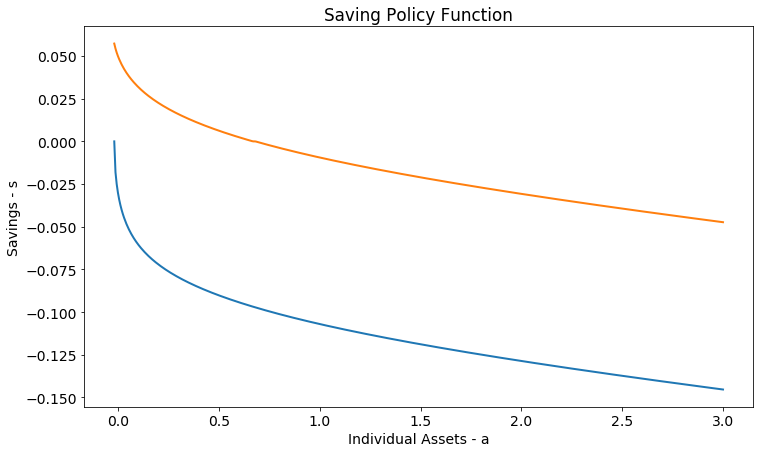

In [22]:
V,s,c = hh_iter(v, r, gamma, rho, a, y, La)
plt.figure(figsize=(12,7))
plt.rc('font', size=14)
plt.plot(a,s,linewidth = 2.0)
plt.xlabel('Individual Assets - a')
plt.ylabel('Savings - s')
plt.title('Saving Policy Function')
plt.show()

### 1.3 Methods for Stationary Distribution

We start by defining a function $dist$_$iterate$ that iterates on the distribution using the transition matrix formed by the policy functions. 

In [27]:
@njit
def forward_iterate2(D, Pi_T, s, La, Delta, da):

    # First, create the transition matrix
    Tr = Delta*s/da
    TrR = np.maximum(Tr,0)
    TrL = -np.minimum(Tr,0)
    
    Dnew = np.zeros_like(D)
    for i in range(D.shape[0]-1):
        for j in range(D.shape[1]):
            d = D[i,j]
            di = D[i+1,j]
            Dnew[i, j] += d + di*TrL[i+1,j] - d*TrR[i,j]
            Dnew[i+1, j] += d*TrR[i,j] - di*TrL[i+1,j]
            
    Dnew = Dnew + D@(np.transpose(Delta*La))
    
    return Dnew

Now we define a function to compute the steady state distribution by finding fixed point of the method above.

In [25]:
def dist_ss2(D_seed, Pi, s, Delta, da, tol=1E-10, maxit=50_000):

    D = D_seed
    Pi_T = Pi
    
    for it in range(maxit):
        Dnew = forward_iterate2(D, Pi_T, s, La, Delta, da)
        
        # only check convergence every 5 iterations for efficiency
        if it % 5 == 0 and r1.within_tolerance(D, Dnew, tol):
            break
        D = Dnew
    else:
        raise ValueError(f'No convergence after {maxit} forward iterations!')
        
    D = Dnew
    
    return D/da

We can now easily compute the steady state distribution by calling the method above and providing an initial guess for the distribution as input. 

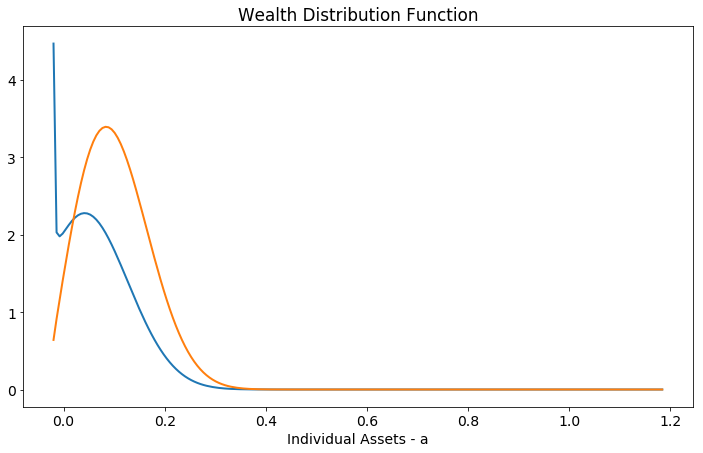

In [26]:
# Initial guess for the distribution - uniform:
g = np.ones([I,J])/(I*J)
D = dist_ss2(g, La, s, Delta, da)

plt.figure(figsize=(12,7))
plt.rc('font', size=14)
plt.plot(a[0:200],D[0:200,:], linewidth = 2.0)
plt.xlabel('Individual Assets - a')
plt.title('Wealth Distribution Function')
plt.show()

### 1.4 Methods to Compute Aggregates: